In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans, AgglomerativeClustering
from pso_clustering import PSOClusteringSwarm

from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data.csv")
df = df.sort_values('Value', ascending = False).reset_index().drop(['index', 'Unnamed: 0'], axis = 1).copy()

df.shape

(144750, 63)

## Data Cleaning

In [3]:
country = ['Ligue 1 Conforama', 'English Premier Division', 'Bundesliga', 'Italian Serie A', 'Spanish First Division']

In [4]:
df[(df['Club'] == 'Watford')]['Division'].unique()

array(['Sky Bet Championship', 'Italian Serie A',
       'English Premier Division'], dtype=object)

In [5]:
df[(df['Club'] == 'Watford')] = df[(df['Club'] == 'Watford')].replace(df[(df['Club'] == 'Watford')]['Division'].unique(), country[1])
df[(df['Club'] == 'Watford')]['Division'].unique()

array(['English Premier Division'], dtype=object)

In [6]:
df[df['Club'].isin(['Espanyol', 'LeganÃ©s', 'Mallorca', 'Osasuna'])]['Division'].unique()

array(['Spanish Second Division', 'Spanish First Division',
       'English Premier Division', 'Spanish Third Division Group 9',
       'Portuguese Second League', 'Argentine Torneo Federal A',
       'Brazilian National Lower Division'], dtype=object)

In [7]:
df[df['Club'].isin(['Espanyol', 'LeganÃ©s', 'Mallorca', 'Osasuna'])] = df[df['Club'].isin(['Espanyol', 'LeganÃ©s', 'Mallorca', 'Osasuna'])].replace(df[df['Club'].isin(['Espanyol', 'LeganÃ©s', 'Mallorca', 'Osasuna'])]['Division'].unique(), country[4])
df[df['Club'].isin(['Espanyol', 'LeganÃ©s', 'Mallorca', 'Osasuna'])]['Division'].unique()

array(['Spanish First Division'], dtype=object)

In [8]:
df = df[df['Division'].isin(country)].reset_index(drop = True)

df.head()

,Name,Position,Club,Division,Based,Nation,Height,Weight,Age,Preferred Foot,...,Cmp,Com,Cmd,Bra,Bal,Ant,Agi,Agg,Aer,Acc
0,Neymar,"M (L), AM (LC), ST (C)",Paris SG,Ligue 1 Conforama,France (Ligue 1 Conforama),BRA,175,68,27,Right,...,17,3,1,14,14,16,18,10,4,17
1,Kevin De Bruyne,"M (RLC), AM (C)",Man City,English Premier Division,England (Premier Division),BEL,181,70,27,Either,...,15,2,2,14,14,13,13,12,2,15
2,Kylian MbappÃ©,"AM (RL), ST (C)",Paris SG,Ligue 1 Conforama,France (Ligue 1 Conforama),FRA,178,73,20,Right,...,18,2,1,12,14,17,16,6,4,20
3,Robert Lewandowski,ST (C),FC Bayern,Bundesliga,Germany (Bundesliga),POL,184,78,30,Right,...,17,3,2,18,20,15,13,18,1,14
4,Mohamed Salah,"AM (RL), ST (C)",Liverpool,English Premier Division,England (Premier Division),EGY,175,72,27,Left,...,15,1,2,11,17,16,16,10,3,18


In [9]:
clubs = ['CÃ¡diz', 'Elche', 'Huesca']

for i in country:
    ct_clubs = list(df[df['Division'] == i].groupby(['Club', 'Division']).agg({'Name' : len}).sort_values('Name').query('Name < 3').reset_index().Club.unique())
    for club in ct_clubs:
        clubs.append(club)
        
print("Number of teams to be dropped: {}".format(len(clubs)))

Number of teams to be dropped: 63


In [10]:
indexToBeDrop = df[df['Club'].isin(clubs)].index
df.drop(indexToBeDrop, inplace=True)
df.head()

,Name,Position,Club,Division,Based,Nation,Height,Weight,Age,Preferred Foot,...,Cmp,Com,Cmd,Bra,Bal,Ant,Agi,Agg,Aer,Acc
0,Neymar,"M (L), AM (LC), ST (C)",Paris SG,Ligue 1 Conforama,France (Ligue 1 Conforama),BRA,175,68,27,Right,...,17,3,1,14,14,16,18,10,4,17
1,Kevin De Bruyne,"M (RLC), AM (C)",Man City,English Premier Division,England (Premier Division),BEL,181,70,27,Either,...,15,2,2,14,14,13,13,12,2,15
2,Kylian MbappÃ©,"AM (RL), ST (C)",Paris SG,Ligue 1 Conforama,France (Ligue 1 Conforama),FRA,178,73,20,Right,...,18,2,1,12,14,17,16,6,4,20
3,Robert Lewandowski,ST (C),FC Bayern,Bundesliga,Germany (Bundesliga),POL,184,78,30,Right,...,17,3,2,18,20,15,13,18,1,14
6,Sergio AgÃ¼ero,"AM (C), ST (C)",Man City,English Premier Division,England (Premier Division),ARG,172,74,31,Either,...,16,2,1,14,20,16,18,14,3,17


In [11]:
print("Number of teams remained: {}".format(df['Club'].unique().shape))
display(df.groupby(['Division', 'Club']).agg({'Name' : len}).sort_values('Name').reset_index().groupby('Division').agg({'Club' : len}))

Number of teams remained: (98,)


,Club
Division,
Bundesliga,18
English Premier Division,20
Italian Serie A,20
Ligue 1 Conforama,20
Spanish First Division,20


In [12]:
df_new = df[['Name', 'Position', 'Club', 'Division', 'Nation', 'Height',
       'Weight', 'Age', 'Preferred Foot', 'Best Pos', 'Best Role', 'Value',
       'Wage', 'CA', 'PA']]

# Avg. for Set Pieces
df_new['SP'] = df[['Pen', 'Fre', 'Cor']].mean(axis = 1)

# Avg. for Goalkeeping Attributes
df_new['GK'] = df[['Thr', 'TRO', 'Ref', 'Pun', 'Pas', '1v1', 'Kic', 'Han', 'Fir', 'Ecc', 'Com', 'Cmd', 'Aer']].mean(axis = 1)

# Avg. for Defensive Attributes
df_new['DA'] = df[['Tck', 'Mar', 'Pos', 'Hea', 'Bra', 'Agg']].mean(axis = 1)

# Avg. for Offensive Attributes
df_new['OA'] = df[['Fir', 'Fin', 'OtB', 'Fla']].mean(axis = 1)

df_new.head()

,Name,Position,Club,Division,Nation,Height,Weight,Age,Preferred Foot,Best Pos,Best Role,Value,Wage,CA,PA,SP,GK,DA,OA
0,Neymar,"M (L), AM (LC), ST (C)",Paris SG,Ligue 1 Conforama,BRA,175,68,27,Right,AM (L),IW,91000000,600000,186,190,16.666667,4.307692,6.000000,18.00
1,Kevin De Bruyne,"M (RLC), AM (C)",Man City,English Premier Division,BEL,181,70,27,Either,M (C),MEZ,88000000,230000,188,188,14.000000,4.538462,9.500000,15.50
2,Kylian MbappÃ©,"AM (RL), ST (C)",Paris SG,Ligue 1 Conforama,FRA,178,73,20,Right,ST (C),AF,86000000,375000,181,196,11.666667,4.153846,5.166667,17.25
3,Robert Lewandowski,ST (C),FC Bayern,Bundesliga,POL,184,78,30,Right,ST (C),PF,80000000,325000,184,184,13.333333,3.923077,12.166667,16.75
6,Sergio AgÃ¼ero,"AM (C), ST (C)",Man City,English Premier Division,ARG,172,74,31,Either,ST (C),AF,78000000,230000,178,183,11.333333,4.461538,9.333333,16.75


In [13]:
df_new['Best Pos'].value_counts()

M (C)     875
D (C)     862
ST (C)    724
GK        570
D (R)     392
D (L)     354
AM (R)    298
AM (L)    292
AM (C)    258
DM        225
M (L)      99
M (R)      95
WB (R)     16
WB (L)     14
Name: Best Pos, dtype: int64

In [14]:
df_atts = df[['Wor', 'Vis', 'Thr', 'Tec', 'Tea', 'Tck', 'Str',
       'Sta', 'TRO', 'Ref', 'Pun', 'Pos', 'Pen', 'Pas', 'Pac', '1v1', 'OtB',
       'Nat', 'Mar', 'L Th', 'Lon', 'Ldr', 'Kic', 'Jum', 'Hea', 'Han', 'Fre',
       'Fla', 'Fir', 'Fin', 'Ecc', 'Dri', 'Det', 'Dec', 'Cro', 'Cor', 'Cnt',
       'Cmp', 'Com', 'Cmd', 'Bra', 'Bal', 'Ant', 'Agi', 'Agg', 'Aer', 'Acc']].copy()

df_atts.head()

,Wor,Vis,Thr,Tec,Tea,Tck,Str,Sta,TRO,Ref,...,Cmp,Com,Cmd,Bra,Bal,Ant,Agi,Agg,Aer,Acc
0,10,16,1,20,8,1,10,13,1,4,...,17,3,1,14,14,16,18,10,4,17
1,15,20,3,17,14,9,13,17,2,3,...,15,2,2,14,14,13,13,12,2,15
2,10,13,1,17,10,2,11,14,2,1,...,18,2,1,12,14,17,16,6,4,20
3,18,13,2,16,16,7,16,19,3,1,...,17,3,2,18,20,15,13,18,1,14
6,13,14,3,18,12,5,13,16,3,2,...,16,2,1,14,20,16,18,14,3,17


## Agglomerative Clustering

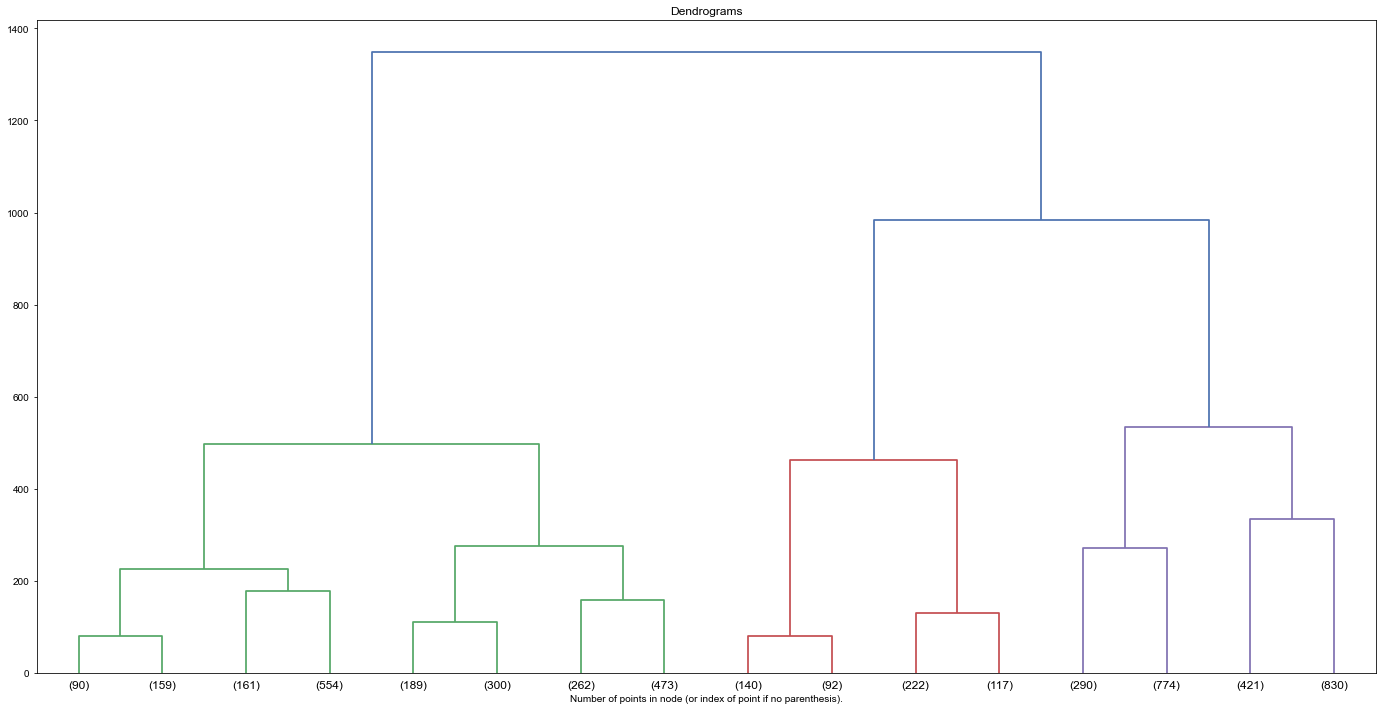

In [15]:
fig = plt.figure(figsize=(24,12))
plt.title("Dendrograms")
plt.style.use("seaborn")
dend = shc.dendrogram(shc.linkage(df_atts, method='ward',metric='euclidean'),p=3,truncate_mode = 'level')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [16]:
model = AgglomerativeClustering(n_clusters = 17, affinity = "euclidean", linkage = "ward")
model = model.fit(df_atts)
cluster_labels=model.labels_
score = silhouette_score(df_atts, cluster_labels)
print(score)

0.1130272600181608


In [17]:
df_new['hcluster'] = cluster_labels

In [18]:
df_new['hcluster'].value_counts()

1     554
7     489
6     421
9     387
8     360
4     348
2     345
0     339
3     290
13    262
10    249
14    235
5     232
11    194
12    161
15    113
16     95
Name: hcluster, dtype: int64

<AxesSubplot:xlabel='DA', ylabel='OA'>

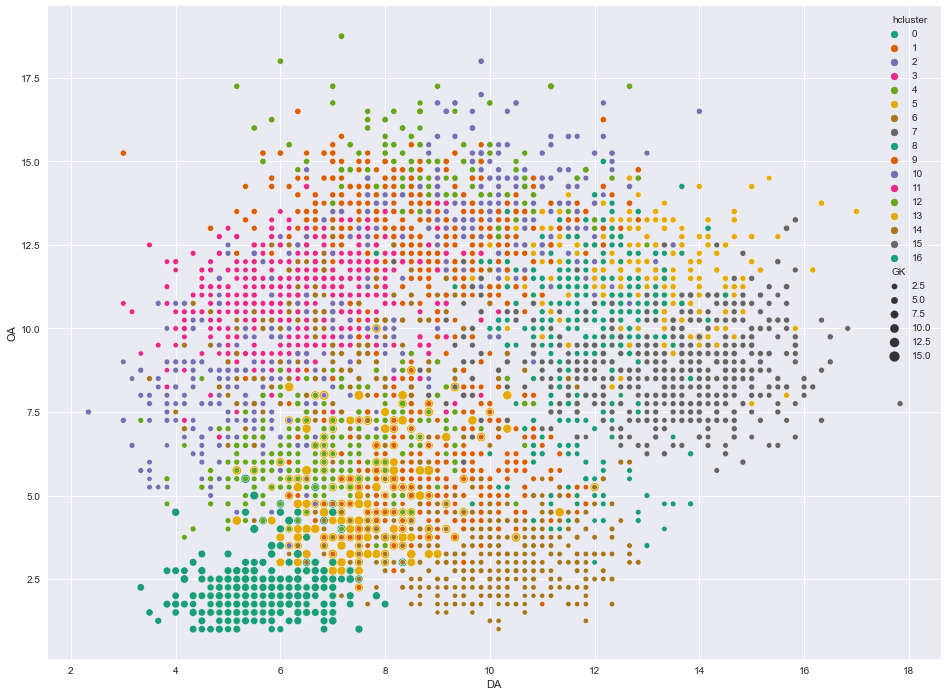

In [19]:
fig, ax = plt.subplots(figsize=(16,12))
sns.set_style("darkgrid")
sns.scatterplot(data= df_new, x="DA", y="OA", size = "GK", hue = "hcluster", palette = "Dark2")

In [20]:
df_mean = df_new.groupby('hcluster').agg(['mean']).T.reset_index()
df_mean.index = df_mean['level_0']
df_mean = df_mean.drop(columns = ['level_0','level_1']).T
df_mean

level_0,Height,Weight,Age,Value,Wage,CA,PA,SP,GK,DA,OA
hcluster,,,,,,,,,,,
0,186.775811,73.380531,17.144543,3.617426e+04,464.587021,62.504425,102.035398,3.966568,7.970955,5.675025,2.152655
1,178.061372,71.166065,22.806859,7.642464e+06,25727.021661,123.953069,142.274368,10.247894,3.737295,8.540313,12.822202
2,177.408696,65.275362,16.802899,4.301638e+04,323.971014,63.249275,104.750725,5.320773,3.231215,5.748792,8.936232
3,180.175862,67.817241,16.610345,3.086655e+04,256.241379,58.568966,99.427586,4.571264,3.033687,5.756322,10.770690
4,176.612069,64.301724,16.537356,2.606968e+04,260.316092,57.290230,99.752874,4.189655,3.525641,7.033046,6.290948
5,189.862069,83.038793,27.422414,7.526741e+06,33708.836207,127.892241,141.474138,5.991379,11.997016,7.608477,4.908405
6,183.456057,70.660333,16.612827,2.288029e+04,262.042755,56.783848,97.807601,2.381631,2.658323,10.034046,3.268409
7,186.607362,79.967280,26.057260,1.033964e+07,37524.580777,132.376278,144.400818,6.405590,3.576373,13.894001,8.825153
8,179.380556,73.469444,25.033333,7.118610e+06,26895.902778,128.019444,139.950000,8.785185,3.641667,11.825000,10.873611


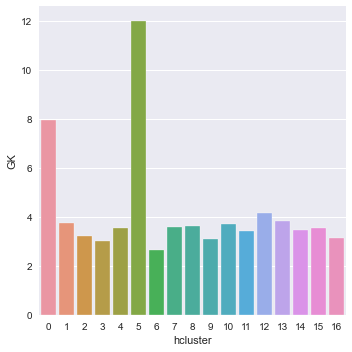

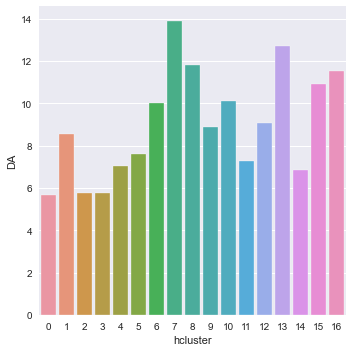

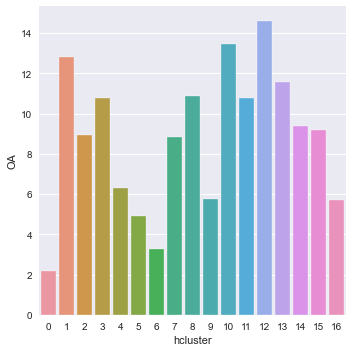

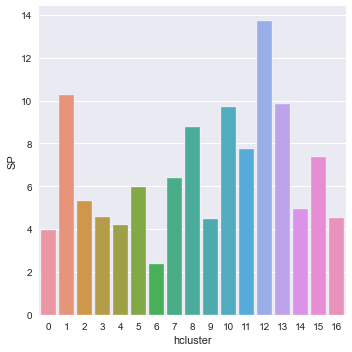

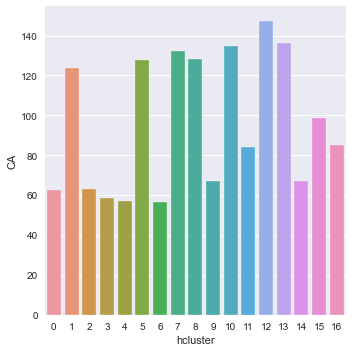

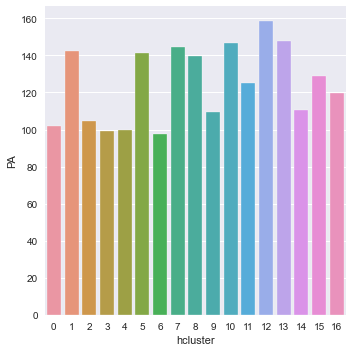

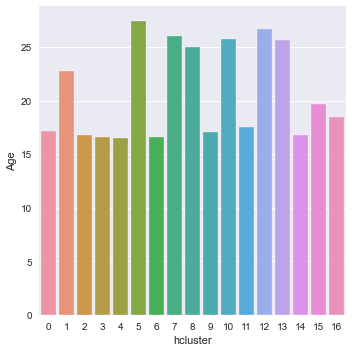

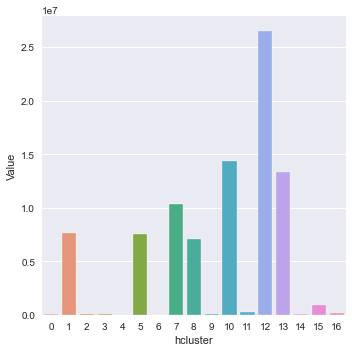

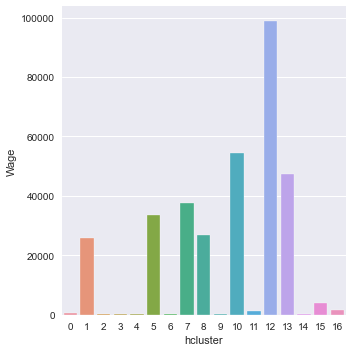

In [21]:
for col in ['GK', 'DA', 'OA', 'SP', 'CA', 'PA', 'Age', 'Value', 'Wage']:
    sns.catplot(x = 'hcluster', y = col, data = df_mean.reset_index(), kind = 'bar')

### Agglomerative Clustering Results

0 - Young Goalkeepers

1 - Elite wingers or attackers

2 - Young centerforwards with OA-DA distance is high.

3 - Young centerforwards with OA-DA distance is low.

4 - Average defensive midfielders and similar players.

5 - Elite Goalkeepers

6 - Good defenders having both fullback and centreback traits.

7 - Elite central defenders and related players

8 - Elite fullbacks

9 - Average fullbacks

10 - Elite centerforwards

11 - Young wingers with high potential

12 - Advanced playmakers with great Set Pieces and Offensive Attributes average.

13 - Good central midfielders and average central defenders

14 - Mostly players with high pressing and passing skills.

15 - Players having similar skills in defensive and set pieces attributes.

16 - Defenders with high potential

## PSO Clustering

In [41]:
pso = PSOClusteringSwarm(n_clusters = 17, n_particles=10, data=df_atts.values, hybrid=True, c1 = 1.49, c2 = 1.49)
clusters, global_best_fitness = pso.start(iteration=1000, plot = False)

*** Initialing swarm with 10 PARTICLES,  17 CLUSTERS with 1000 MAX ITERATIONS and with PLOT = False ***
Data= 5074 points in 47 dimensions
iteration 0 GB = inf
best clusters so far =  None
iteration 200 GB = 12.128801893781674
best clusters so far =  [15 15 15 ... 16 12 12]
iteration 400 GB = 11.537105798584099
best clusters so far =  [15 15 15 ... 16 12 12]
iteration 600 GB = 11.537105798584099
best clusters so far =  [15 15 15 ... 16 12 12]
iteration 800 GB = 11.537105798584099
best clusters so far =  [15 15 15 ... 16 12 12]
Finished!


In [42]:
df_new['pso_cluster'] = clusters

<AxesSubplot:xlabel='DA', ylabel='OA'>

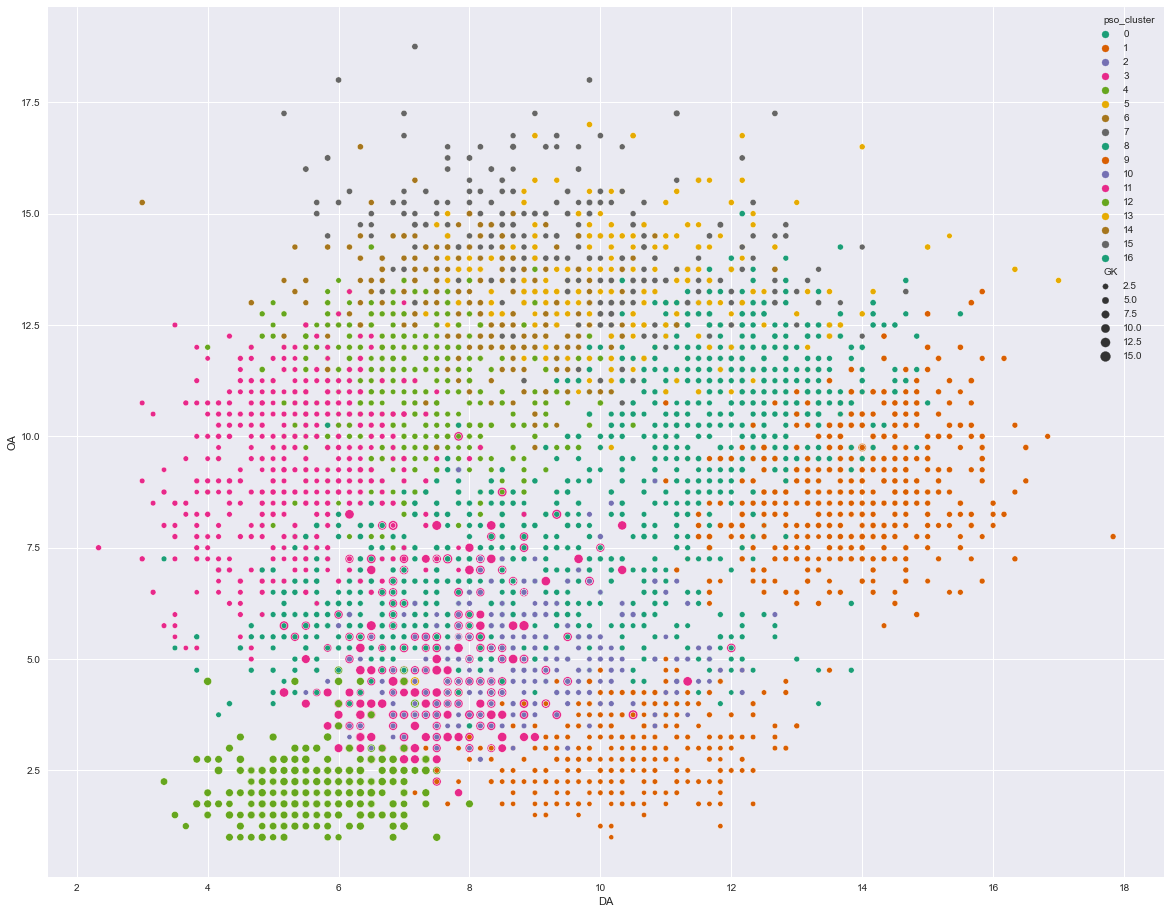

In [43]:
fig, ax = plt.subplots(figsize=(20,16))
sns.set_style("darkgrid")
sns.scatterplot(data= df_new, x="DA", y="OA", size = "GK", hue = "pso_cluster", palette = "Dark2")

In [44]:
df_new['pso_cluster'].value_counts()

8     616
1     527
11    511
12    472
6     394
0     382
15    342
10    337
9     336
4     321
5     295
16    289
3     245
13      4
2       1
14      1
7       1
Name: pso_cluster, dtype: int64

In [45]:
print('DBI: ' + str(davies_bouldin_score(df_atts.values, clusters)))
print('SS: ' + str(silhouette_score(df_atts.values, clusters)))

DBI: 1.9819236598584586
SS: 0.09879487381762005


In [46]:
df_mean = df_new.groupby('pso_cluster').agg(['mean']).T.reset_index()
df_mean.index = df_mean['level_0']
df_mean = df_mean.drop(columns = ['level_0','level_1']).T
df_mean

level_0,Height,Weight,Age,Value,Wage,CA,PA,SP,GK,DA,OA
pso_cluster,,,,,,,,,,,
0,176.811518,64.387435,16.578534,2.269045e+04,250.274869,56.916230,99.722513,4.216405,3.526782,6.925829,6.469895
1,186.603416,79.886148,25.914611,1.012458e+07,36626.736243,131.525617,144.130930,6.530677,3.592176,13.871600,8.807875
2,174.000000,65.000000,18.000000,1.450000e+05,700.000000,88.000000,114.000000,7.333333,3.307692,7.333333,10.000000
3,189.906122,82.914286,27.130612,7.020232e+06,31781.142857,125.371429,139.881633,5.923810,11.859655,7.503401,4.814286
4,186.610592,72.965732,16.866044,3.038419e+04,342.492212,60.915888,101.015576,3.897196,7.852624,5.631880,2.063084
5,184.942373,79.162712,25.440678,1.172361e+07,43750.728814,131.928814,144.576271,9.396610,3.638070,10.242938,13.216949
6,177.345178,70.502538,22.068528,6.371727e+06,20868.020305,120.540609,140.997462,9.946701,3.702655,8.053723,12.708756
7,173.000000,62.000000,16.000000,9.500000e+03,220.000000,45.000000,90.000000,3.000000,3.769231,5.666667,4.750000
8,179.681818,73.508117,24.509740,7.672051e+06,27368.887987,127.344156,141.147727,8.731061,3.673452,11.987825,10.900974


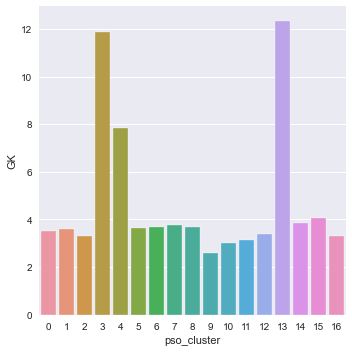

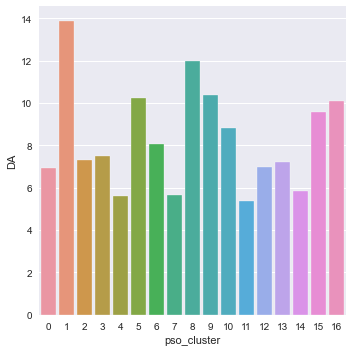

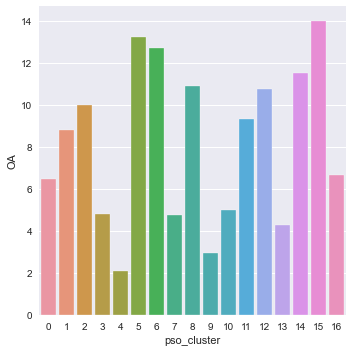

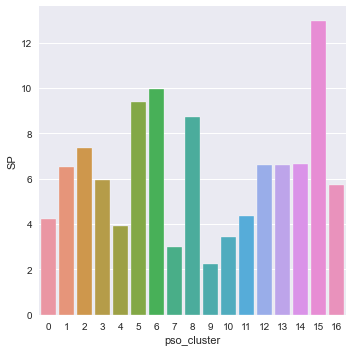

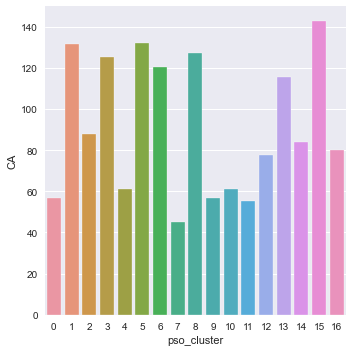

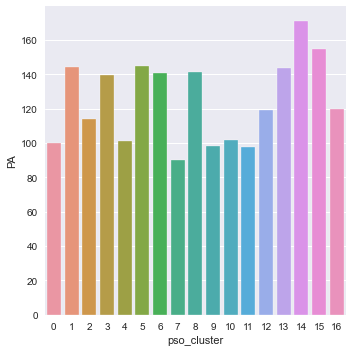

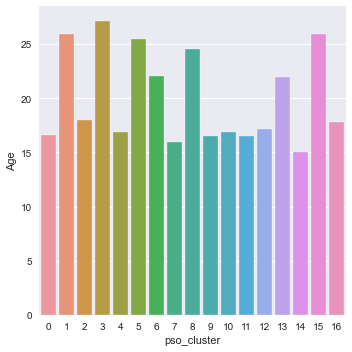

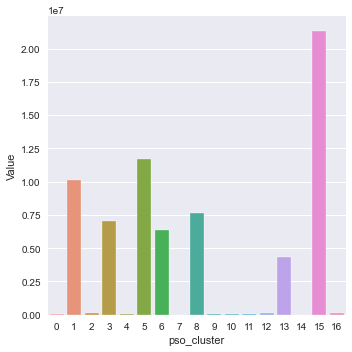

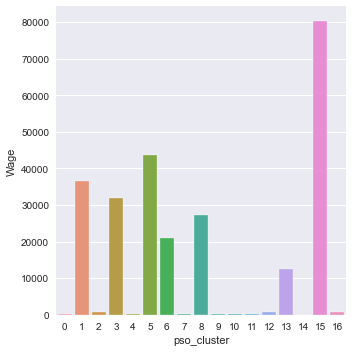

In [47]:
for col in ['GK', 'DA', 'OA', 'SP', 'CA', 'PA', 'Age', 'Value', 'Wage']:
    sns.catplot(x = 'pso_cluster', y = col, data = df_mean.reset_index(), kind = 'bar')

### PSO Clustering Results

0 - Midfielders having below average scores in all fields.

1 - Elite centraldefenders

2 - Only one player

3 - Elite and older goalkeepers

4 - Young goalkeepers

5 - Elite centreforwards

6 - Elite wingers

7 - Only one player

8 - Elite Fullbacks and defensive midfielders having OA-DA balance

9 - Young centraldefenders with low PA

10 - Defensive fullbacks and not elite centralforwards

11 - Attacking players with below average scores.

12 - Young players with good PA and OA mean

13 - Elite and younger goalkeepers

14 - Young offensive players with great PA

15 - Elite playmakers

16 - Young centraldefenders with high PA